# 🏦 Loan Analysis Training Pipeline

https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction 




In [1]:
# !pip uninstall hopsworks -y 

In [2]:
!pip install hopsworks

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

## 🔖 Hopsworks Feature Store

In [4]:
import hopsworks

proj = hopsworks.login()
fs = proj.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398


Connected. Call `.close()` to terminate connection gracefully.


## Create the Feature View

In [5]:
fg_loans = fs.get_feature_group(name="loans", version=1)
fg_applicants = fs.get_feature_group(name="applicants", version=1)

query = fg_loans.select_except(["id", "issue_d"]).join(\
            fg_applicants.select_except(["earliest_cr_line", "earliest_cr_line_year", "id"]))

In [6]:
fv_version=1
try:
    fv = fs.get_feature_view(name="loans_approvals", version=fv_version)
except:
    fv = fs.create_feature_view(name="loans_approvals", 
                       version=fv_version,
                        description="Loan applicant data",
                        labels=["loan_status"],
                        query=query
                       )

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fv/loans_approvals/version/2


In [7]:
start_time = time.time()

X_train, X_test, y_train, y_test = fv.train_test_split(test_size=0.2)

print("Get Random Split Training Data in %s seconds ---" % (time.time() - start_time))

2023-05-08 22:47:53,294 INFO: USE `dowlingj_featurestore`
2023-05-08 22:47:54,019 INFO: WITH right_fg0 AS (SELECT *
FROM (SELECT `fg1`.`loan_amnt` `loan_amnt`, `fg1`.`term` `term`, `fg1`.`int_rate` `int_rate`, `fg1`.`installment` `installment`, `fg1`.`sub_grade` `sub_grade`, `fg1`.`loan_status` `loan_status`, `fg1`.`purpose` `purpose`, `fg1`.`zip_code` `zip_code`, `fg1`.`id` `join_pk_id`, `fg1`.`issue_d` `join_evt_issue_d`, `fg0`.`home_ownership` `home_ownership`, `fg0`.`annual_inc` `annual_inc`, `fg0`.`verification_status` `verification_status`, `fg0`.`dti` `dti`, `fg0`.`open_acc` `open_acc`, `fg0`.`pub_rec` `pub_rec`, `fg0`.`revol_bal` `revol_bal`, `fg0`.`revol_util` `revol_util`, `fg0`.`total_acc` `total_acc`, `fg0`.`initial_list_status` `initial_list_status`, `fg0`.`application_type` `application_type`, `fg0`.`mort_acc` `mort_acc`, `fg0`.`pub_rec_bankruptcies` `pub_rec_bankruptcies`, RANK() OVER (PARTITION BY `fg1`.`id`, `fg1`.`issue_d` ORDER BY `fg0`.`earliest_cr_line` DESC) pit_r

In [23]:
X_test

,loan_amnt,term,int_rate,installment,sub_grade,purpose,zip_code,home_ownership,annual_inc,verification_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
6,18000.00,36 months,5.32,542.07,A1,home_improvement,22690,MORTGAGE,125000.00,Source Verified,1.36,8.00,0,4178.00,4.90,25.00,f,INDIVIDUAL,3.00,0.00
8,18900.00,60 months,10.99,410.84,B3,debt_consolidation,22690,RENT,103000.00,Verified,12.52,13.00,0,18637.00,32.90,40.00,w,INDIVIDUAL,3.00,0.00
11,35000.00,36 months,14.64,1207.13,C3,credit_card,0,MORTGAGE,130000.00,Verified,12.19,30.00,0,81263.00,18.70,61.00,w,INDIVIDUAL,4.00,0.00
13,35000.00,60 months,12.29,783.70,C1,debt_consolidation,29597,MORTGAGE,157000.00,Verified,29.39,17.00,0,113091.00,94.90,27.00,w,INDIVIDUAL,2.00,0.00
21,7350.00,36 months,13.11,248.05,B4,debt_consolidation,0,MORTGAGE,54800.00,Not Verified,7.47,10.00,0,3240.00,37.20,36.00,f,INDIVIDUAL,6.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395180,5600.00,36 months,9.63,179.73,B1,credit_card,29597,RENT,54000.00,Verified,6.84,9.00,0,2776.00,33.00,21.00,f,INDIVIDUAL,2.00,0.00
395191,17500.00,36 months,13.66,595.23,C3,credit_card,70466,RENT,70000.00,Source Verified,19.08,22.00,0,16637.00,88.00,42.00,f,INDIVIDUAL,0.00,0.00
395192,12000.00,36 months,8.18,377.04,B1,debt_consolidation,48052,RENT,56000.00,Not Verified,28.82,13.00,0,6577.00,29.00,22.00,f,INDIVIDUAL,0.00,0.00
395194,33425.00,60 months,17.57,840.98,D4,debt_consolidation,30723,MORTGAGE,75000.00,Source Verified,15.78,8.00,0,16632.00,56.40,23.00,w,INDIVIDUAL,3.00,0.00


In [9]:
y_train

,loan_status
0,Fully Paid
1,Fully Paid
2,Fully Paid
3,Fully Paid
4,Charged Off
...,...
395214,Fully Paid
395215,Fully Paid
395216,Fully Paid
395217,Fully Paid


In [10]:
# Map features to transformation functions.
categorical_features = []
numeric_features = []
for col in X_train.columns:
    if X_train[col].dtype == object:
        categorical_features.append(col)
    else:
        numeric_features.append(col)

print(numeric_features)
print(categorical_features)

['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
['term', 'sub_grade', 'purpose', 'zip_code', 'home_ownership', 'verification_status', 'initial_list_status', 'application_type']


In [11]:
# # Map features to transformation functions.
# categorical_feature_ids = []
# numeric_feature_ids = []
# idx=0
# for col in X_train.columns:
#     if X_train[col].dtype == object:
#         categorical_feature_ids.append(idx)
#     else:
#         numeric_feature_ids.append(idx)
#     idx += 1

# print(categorical_feature_ids)
# print(numeric_feature_ids)

In [12]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectPercentile, chi2

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

# Here, we are passing the column names to the ColumnTransformer 
# in 'numeric_features' and 'categorical_features'
# This means in inference, we also have to pass the names of the columns - you can only do this with a
# Pandas DataFrame. So, that means in online inference, you have to create a Pandas DataFrame to make
# the feature vector. If that is too slow, you should use "ids" here, instead of names, then you can use
# a numpy array instead of a Pandas DataFrame in online inference
# https://stackoverflow.com/questions/71715754/valueerror-specifying-the-columns-using-strings-is-only-supported-for-pandas-da
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [13]:
y_train['loan_status'] = y_train.loan_status.map({'Fully Paid':1, 'Charged Off':0})
y_test['loan_status'] = y_test.loan_status.map({'Fully Paid':1, 'Charged Off':0})

In [14]:
y_train

,loan_status
0,1
1,1
2,1
3,1
4,0
...,...
395214,1
395215,1
395216,1
395217,1


# 🤖 Models Building

In [15]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [16]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_train, y_train['loan_status'].ravel())


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'annual_inc',
                                                   'dti', 'open_acc', 'pub_rec',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'mort_acc',
                                                   'pub_rec_bankruptcies']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7fb416dd8b80>))]),
                                                  ['term', 'sub_grade',
                                                   'purpose', 'zip_code',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'initial_list_status',
                                                   'application_type'])])),
                ('classifier', LogisticRegression())])

In [17]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 88.94%
_______________________________________________
CLASSIFICATION REPORT:
                 0         1  accuracy  macro avg  weighted avg
precision     0.95      0.88      0.89       0.92          0.90
recall        0.46      0.99      0.89       0.73          0.89
f1-score      0.62      0.94      0.89       0.78          0.87
support   61878.00 254297.00      0.89  316175.00     316175.00
_______________________________________________
Confusion Matrix: 
 [[ 28466  33412]
 [  1547 252750]]

Test Result:
Accuracy Score: 88.72%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     0.95     0.88      0.89       0.91          0.89
recall        0.46     0.99      0.89       0.72          0.89
f1-score      0.62     0.93      0.89       0.77          0.87
support   15645.00 63399.00      0.89   79044.00      79044.00
______________________________________________

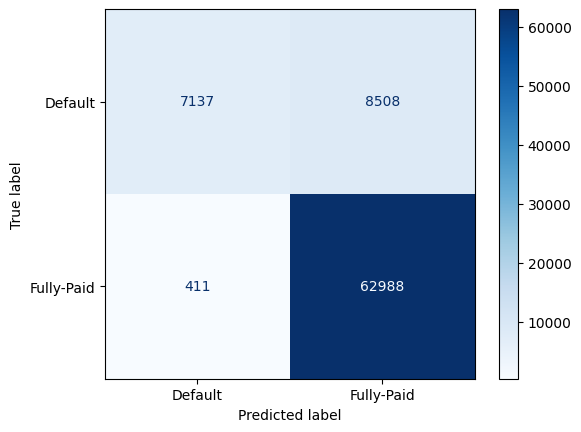

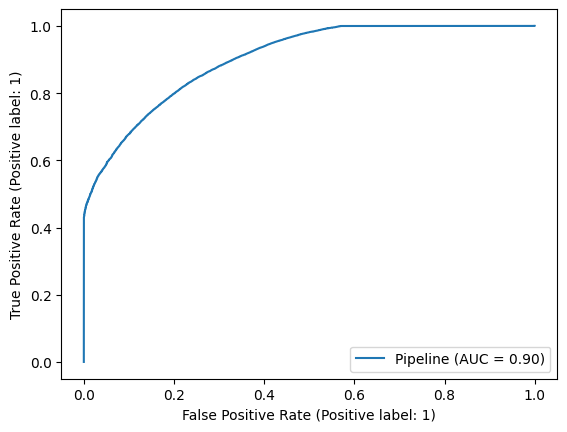

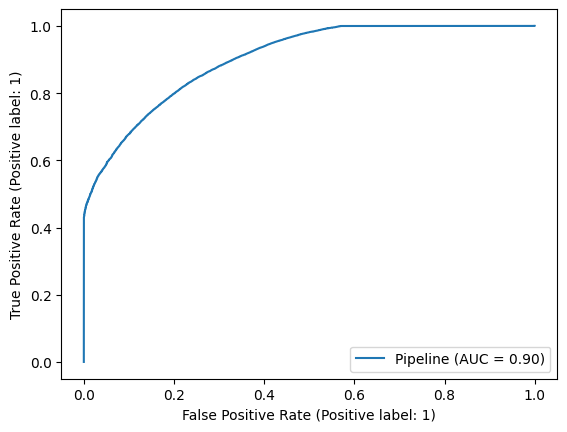

In [18]:
disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

display = RocCurveDisplay.from_estimator(clf, X_test, y_test)
display.plot()

# ✔️ Register the Model with Model Registry

In [19]:
mr = proj.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [20]:
import joblib
import os
os.makedirs("lending_model/features", exist_ok=True)
plt.savefig('lending_model/roc_curve.png')
joblib.dump(clf, 'lending_model/lending_model.pkl')

accuracy = roc_auc_score(y_test, clf.predict(X_test))

<Figure size 640x480 with 0 Axes>

In [21]:
accuracy

0.7248506661390612

In [22]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_test)
output_schema = Schema(y_test)

fraud_model = mr.sklearn.create_model("lending_model",
                                      metrics={'accuracy': accuracy},
                                      input_example=X_test.sample().to_numpy(), 
                                      model_schema=ModelSchema(input_schema=input_schema, output_schema=output_schema))
fraud_model.save('lending_model')

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/398/models/lending_model/9


Model(name: 'lending_model', version: 9)